In [1]:
# bibliotecas necessárias para simular o potencial do oscilador harmônico

import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt


In [10]:
from google.colab import auth
auth.authenticate_user()

MessageError: Error: credential propagation was unsuccessful

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/15000], Loss: 0.3026691079, MSE: 0.5905209184
Epoch [1001/15000], Loss: 0.0348951593, MSE: 0.2424177229
Epoch [2001/15000], Loss: 0.0118914768, MSE: 0.0899252445
Epoch [3001/15000], Loss: 0.0000615212, MSE: 0.0002006002
Epoch [4001/15000], Loss: 0.0000091891, MSE: 0.0000012348
Epoch [5001/15000], Loss: 0.0000040616, MSE: 0.0000000095
Epoch [6001/15000], Loss: 0.0000030170, MSE: 0.0000000721
Epoch [7001/15000], Loss: 0.0000025091, MSE: 0.0000000633
Epoch [8001/15000], Loss: 0.0000020795, MSE: 0.0000000452
Epoch [9001/15000], Loss: 0.0000016734, MSE: 0.0000000347
Epoch [10001/15000], Loss: 0.0000013544, MSE: 0.0000000263
Epoch [11001/15000], Loss: 0.0000011701, MSE: 0.0000000185
Epoch [12001/15000], Loss: 0.0000010522, MSE: 0.0000000182
Epoch [13001/15000], Loss: 0.0000009612, MSE: 0.0000000142
Epoch [14001/15000], Loss: 0.0000008303, MSE: 0.0000000109

Model Summary:
OdeSecond(
  (dense1): Linear(in_features=1, out_features=32, bias=True)
  (dense2): Linear(in_features=32, out_

<ipython-input-5-92938ba60dbe>:93: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[1, 1].legend()


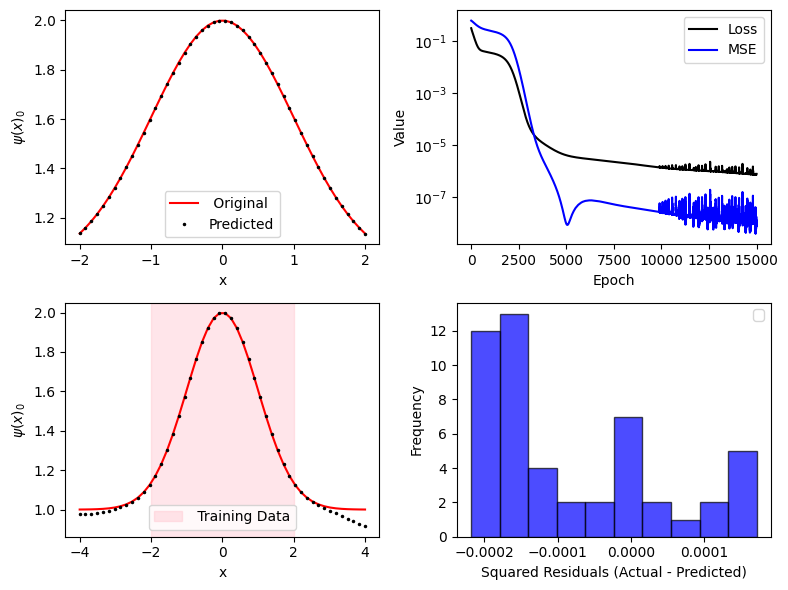

In [5]:
# psi_0
# variáveis

A0 = 1
m  = 1
omega = 1
planck = 1
L_init = -2
L_end = 2


class OdeSecond(nn.Module):
    def __init__(self):
        super(OdeSecond, self).__init__()
        self.dense1 = nn.Linear(1, 32)
        self.dense2 = nn.Linear(32, 32)
        self.dense3 = nn.Linear(32, 1)

    def forward(self, x):
        x = torch.sin(self.dense1(x))
        x = torch.sin(self.dense2(x))
        return self.dense3(x)


# Funções de treinamento
def train_step(model, optimizer, loss_fn, x_train1, y_train1, L, xi):
    x_train_tensor = torch.tensor(x_train1, dtype=torch.float32, requires_grad=True)
    y_train_tensor = torch.tensor(y_train1, dtype=torch.float32)
    optimizer.zero_grad()

    x0 = torch.tensor([L_init], dtype=torch.float32, requires_grad=True)
    y0_exact = torch.tensor([[ A0 * np.exp(-(0.5*L_init**2)) ]], dtype=torch.float32)
    dy_dx0_exact = torch.tensor([  L_init * A0 * np.exp(-0.5*L_init**2) ], dtype=torch.float32)

    xL = torch.tensor([ L_end ], dtype=torch.float32, requires_grad=True)
    yL_exact = torch.tensor([   A0 * np.exp(-0.5*(L_end**2)) ], dtype=torch.float32)

    y0_NN = model(x0)
    dy_dx0_NN = torch.autograd.grad(y0_NN.sum(), x0, create_graph=True)[0]
    yL_NN = model(xL)

    y_NN = model(x_train_tensor)
    dy_dx_NN = torch.autograd.grad(y_NN.sum(), x_train_tensor, create_graph=True)[0]
    d2y_dx2_NN = torch.autograd.grad(dy_dx_NN.sum(), x_train_tensor, create_graph=True)[0]

    loss = (
         loss_fn(y0_NN, y0_exact)
         +loss_fn(d2y_dx2_NN, -y_NN*(1 - xi**2))
         +loss_fn(dy_dx0_NN, -dy_dx0_exact)
         +loss_fn(yL_NN, yL_exact))

    loss.backward()
    optimizer.step()

    mse = nn.MSELoss()(y_NN, y_train_tensor)
    return loss.item(), mse.item()

def plot_grafics(model, x_train, y_train, x_test, y_test, loss_values, mse_values):
  """retorna o subplot da predição, erro, ruído e gráfico do conjunto de validação"""

  model.eval()
  x_test_tensor = torch.linspace(L_init, L_end, 50).unsqueeze(1)
  with torch.no_grad(): y_pred = model(x_test_tensor).numpy()
  fig, ax = plt.subplots(2, 2, figsize=(8, 6))

  #primeiro subplot previsão da rede neural
  ax[0, 0].plot(x_train, (omega*planck) + y_train, markersize=5,  color='red', alpha=1, label=r' Original')
  ax[0, 0].plot(x_test_tensor.numpy(),  (omega*planck) + y_pred,'.', markersize=3,  color='black',  alpha=1, label=r'Predicted')
  ax[0, 0].text(1000, 0,'', fontsize = 0.5)
  ax[0, 0].set_xlabel('x')
  ax[0, 0].set_ylabel(r'$\psi(x)_{0}$')
  ax[0, 0].legend()

  # segundo subplot = loss e mse
  ax[0, 1].set_yscale('log')
  ax[0, 1].plot(loss_values, color='black', label= 'Loss')
  ax[0, 1].plot(mse_values, color='blue', label='MSE')
  ax[0, 1].text(4800, 0.25,'', fontsize=5)
  ax[0, 1].set_xlabel('Epoch')
  ax[0, 1].set_ylabel(r'Value')
  ax[0, 1].legend()


  # terceiro subplot = histograma
  x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
  with torch.no_grad(): y_pred_tensor = model(x_train_tensor)
  residuals = y_train- y_pred_tensor.numpy()

  ax[1, 1].hist(residuals, bins=10, color='blue', alpha=0.7, edgecolor='black')
  ax[1, 1].set_xlabel('Squared Residuals (Actual - Predicted)')
  ax[1, 1].set_ylabel('Frequency')
  #ax[1, 1].set_title('Histograma dos Resíduos Quadrados')
  ax[1, 1].legend()

  # quarto subplot
  x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
  with torch.no_grad():y_pred = model(x_test_tensor).numpy()  # Predição no conjunto de teste
  ax[1, 0].plot(x_test, (omega*planck) + y_test, markersize=5,  color='red', alpha=1)
  ax[1, 0].plot(x_test_tensor.numpy(),  (omega*planck) + y_pred,'.', markersize=3,  color='black',  alpha=1)
  ax[1, 0].text(1000, 0,'', fontsize = 0.5)
  ax[1, 0].axvspan(-2, 2, color='pink', alpha=0.4, label= f' Training Data')
  ax[1, 0].set_xlabel('x')
  ax[1, 0].set_ylabel(r'$\psi(x)_{0}$')
  ax[1, 0].legend()

  plt.savefig('graficoPSI_0.jpeg', dpi = 400,  bbox_inches='tight')  # bbox_inches='tight' ajuda a ajustar a borda)  # Ajuste de espaçamento entre subplots
  plt.tight_layout()
  plt.show()


if __name__ == "__main__":
    x_train = np.sqrt((m*omega)/planck) * np.linspace(L_init, L_end)[:, np.newaxis]
    y_train = A0 * np.exp(0.5*(-x_train**2))

    # Conjunto de teste
    x_test = np.sqrt((m*omega)/planck) *  np.linspace(L_init-2, L_end+2)[:, np.newaxis]
    y_test = A0 * np.exp(-0.5*(x_test**2))

    xi = torch.tensor(x_train, dtype=torch.float32).detach()

    model = OdeSecond()
    optimizer = optim.Adam(model.parameters(), lr=0.00005)
    #optimizer = torch.optim.NAdam(model.parameters(), lr=0.00001, betas=(0.9, 0.999))
    #optimizer = torch.optim.Adamax(model.parameters(), lr=0.002, betas=(0.9, 0.999))   # resultado ruim
    #optimizer = torch.optim.ASGD(model.parameters(), lr=0.01, weight_decay=1e-4)      # ótimo resultado
    #optimizer = torch.optim.Adadelta(model.parameters(), lr=1.0, rho=0.09)
    #optimizer = torch.optim.ASGD(model.parameters(), lr=0.01, weight_decay=1e-7)

    loss_fn = nn.MSELoss()

    epochs = 15000
    loss_values = []
    mse_values = []
    for epoch in range(epochs):
        loss, mse = train_step(model, optimizer, loss_fn, x_train, y_train, L_init, xi)
        loss_values.append(loss)
        mse_values.append(mse)
        if epoch % 1000 == 0:
            print(f"Epoch [{epoch + 1}/{epochs}], Loss: {loss:.10f}, MSE: {mse:.10f}")

    print("\nModel Summary:")
    print(model)

    func_densidade = []
    func_loss = []
    func_solucao =  []

    plot_grafics(model, x_train, y_train, x_test, y_test, loss_values, mse_values)


Epoch [1/15000], Loss: 0.0878329650, MSE: 0.1423315704
Epoch [1001/15000], Loss: 0.0010448415, MSE: 0.0410103947
Epoch [2001/15000], Loss: 0.0000224048, MSE: 0.0005155181
Epoch [3001/15000], Loss: 0.0000026577, MSE: 0.0000009817
Epoch [4001/15000], Loss: 0.0000009151, MSE: 0.0000000518
Epoch [5001/15000], Loss: 0.0000105795, MSE: 0.0000002678
Epoch [6001/15000], Loss: 0.0000001790, MSE: 0.0000000071
Epoch [7001/15000], Loss: 0.0000004340, MSE: 0.0000000261
Epoch [8001/15000], Loss: 0.0000001162, MSE: 0.0000000090
Epoch [9001/15000], Loss: 0.0000001153, MSE: 0.0000000124
Epoch [10001/15000], Loss: 0.0000004050, MSE: 0.0000000022
Epoch [11001/15000], Loss: 0.0000011412, MSE: 0.0000000434
Epoch [12001/15000], Loss: 0.0000011624, MSE: 0.0000000292
Epoch [13001/15000], Loss: 0.0000000625, MSE: 0.0000000345
Epoch [14001/15000], Loss: 0.0000012307, MSE: 0.0000000338

Model Summary:
OdeSecond(
  (dense1): Linear(in_features=1, out_features=16, bias=True)
  (dense2): Linear(in_features=16, out_

<ipython-input-8-195b21e6749d>:108: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[1, 1].legend()


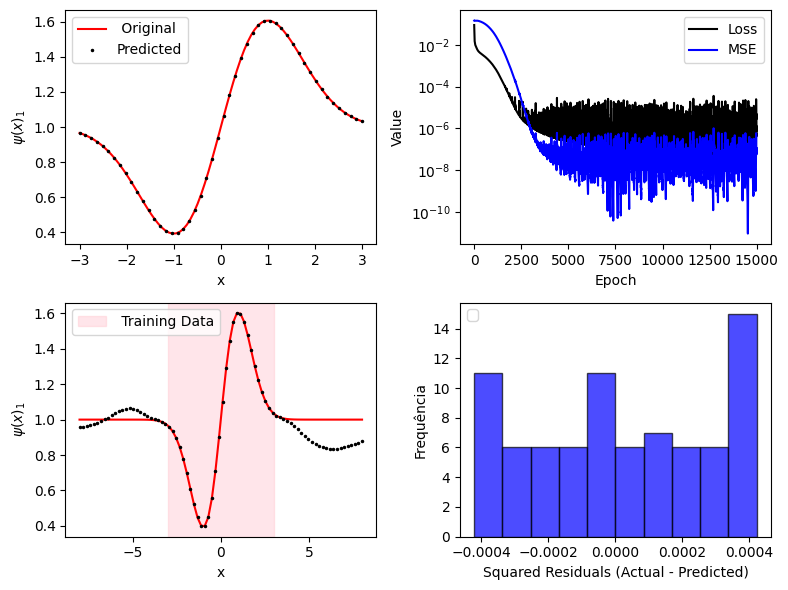

In [8]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

#treinamento na IA
# variáveis
# psi_1
A1 = 1
omega = 1
planck = 1
L_init = -3
L_end = 3
m = 1

k = np.linspace(-2, 2, 100)
potencial = (omega**2) * m * (k**2)

class OdeSecond(nn.Module):
    def __init__(self):
        super(OdeSecond, self).__init__()
        self.dense1 = nn.Linear(1,16)
        self.dense2 = nn.Linear(16,16)
        self.dense3 = nn.Linear(16,1)
        self.sigma = 0.25 # Ajuste o valor de sigma conforme necessário

    def gaussian_activation(self, x):
        return torch.exp(-0.5 * (x / self.sigma)** 2)*x

    def forward(self, x):
        x = self.gaussian_activation(self.dense1(x))
        x = self.gaussian_activation(self.dense2(x))
        return self.dense3(x)

# Funções de treinamento
def train_step(model, optimizer, loss_fn, x_train1, y_train1, L, xi):
    x_train_tensor = torch.tensor(x_train1, dtype=torch.float32, requires_grad=True)
    y_train_tensor = torch.tensor(y_train1, dtype=torch.float32)
    optimizer.zero_grad()

    x0 = torch.tensor([ L_init ], dtype=torch.float32, requires_grad=True)
    y0_exact = torch.tensor([ A1 * L_init * np.exp(-0.5*(L_init**2))], dtype=torch.float32)
    dy_dx0_exact = torch.tensor([  (1 - L_init**2) * A1 * np.exp(-0.5*(L_init**2))], dtype=torch.float32)

    xL = torch.tensor([ L_end ], dtype=torch.float32, requires_grad=True)
    yL_exact = torch.tensor([    A1 * L_end * np.exp(-0.5* (L_end**2))], dtype=torch.float32)

    y0_NN = model(x0)
    dy_dx0_NN = torch.autograd.grad(y0_NN.sum(), x0, create_graph=True)[0]
    yL_NN = model(xL)

    y_NN = model(x_train_tensor)
    dy_dx_NN = torch.autograd.grad(y_NN.sum(), x_train_tensor, create_graph=True)[0]
    d2y_dx2_NN = torch.autograd.grad(dy_dx_NN.sum(), x_train_tensor, create_graph=True)[0]

    loss = (
         loss_fn(y0_NN, y0_exact)
        +loss_fn(d2y_dx2_NN, y_NN*(xi**2 - 3))
        +loss_fn(dy_dx0_NN, dy_dx0_exact)
        +loss_fn(yL_NN, yL_exact))

    loss.backward()
    optimizer.step()

    mse = nn.MSELoss()(y_NN, y_train_tensor)
    return loss.item(), mse.item()



def plot_grafics(model, x_train, y_train, x_test, y_test, loss_values, mse_values):
  """retorna o subplot da predição, erro, ruído e gráfico do conjunto de validação"""

  model.eval()
  x_test_tensor = torch.linspace(L_init, L_end, 50).unsqueeze(1)
  with torch.no_grad(): y_pred = model(x_test_tensor).numpy()
  fig, ax = plt.subplots(2, 2, figsize=(8, 6))

  #primeiro subplot previsão da rede neural
  ax[0, 0].plot(x_train, (omega*planck) + y_train, markersize=5,  color='red', alpha=1, label=r' Original')
  ax[0, 0].plot(x_test_tensor.numpy(),  (omega*planck) + y_pred,'.', markersize=3,  color='black',  alpha=1, label=r'Predicted')
  ax[0, 0].text(1000, 0,'', fontsize = 0.5)
  ax[0, 0].set_xlabel('x')
  ax[0, 0].set_ylabel(r'$\psi(x)_{1}$')
  ax[0, 0].legend()

  # segundo subplot = loss e mse
  ax[0, 1].set_yscale('log')
  ax[0, 1].plot(loss_values, color='black', label= 'Loss')
  ax[0, 1].plot(mse_values, color='blue', label='MSE')
  ax[0, 1].text(4800, 0.25,'', fontsize=5)
  ax[0, 1].set_xlabel('Epoch')
  ax[0, 1].set_ylabel(r'Value')
  ax[0, 1].legend()



  # terceiro subplot = histograma
  x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
  with torch.no_grad(): y_pred_tensor = model(x_train_tensor)
  residuals = y_train - y_pred_tensor.numpy()
  squared = residuals

  ax[1, 1].hist(squared, bins=10, color='blue', alpha=0.7, edgecolor='black')
  ax[1, 1].set_xlabel('Squared Residuals (Actual - Predicted)')
  ax[1, 1].set_ylabel('Frequência')
  #ax[1, 1].set_title('Histograma dos Resíduos Quadrados')
  ax[1, 1].legend()




  # quarto subplot
  x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
  with torch.no_grad():y_pred = model(x_test_tensor).numpy()  # Predição no conjunto de teste
  ax[1, 0].plot(x_test, (omega*planck) + y_test, markersize=5,  color='red', alpha=1)
  ax[1, 0].plot(x_test_tensor.numpy(),  (omega*planck) + y_pred,'.', markersize=3,  color='black',  alpha=1)
  ax[1, 0].text(1000, 0,'', fontsize = 0.5)
  ax[1, 0].axvspan(L_init, L_end, color='pink', alpha=0.4, label= f' Training Data')
  ax[1, 0].set_xlabel('x')
  ax[1, 0].set_ylabel(r'$\psi(x)_{1}$')
  ax[1, 0].legend()

  plt.savefig('graficoPSI_1.jpeg', dpi = 300,  bbox_inches='tight')  # bbox_inches='tight' ajuda a ajustar a borda)  # Ajuste de espaçamento entre subplots
  plt.tight_layout()
  plt.show()

if __name__ == "__main__":

    # treinamento
    x_train = np.sqrt((m*omega)/planck) * np.linspace(L_init, L_end, 80)[:, np.newaxis]
    y_train = A1 * x_train * np.exp(-0.5*(x_train**2))
    xi = torch.tensor(x_train, dtype=torch.float32).detach()

    # teste
    x_test = np.sqrt((m*omega)/planck) * np.linspace(L_init-5, L_end+5, 80)[:, np.newaxis]
    y_test = A1 * x_test * np.exp(-0.5*(x_test**2))

    model = OdeSecond()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    loss_fn = nn.MSELoss()
    epochs = 15000
    loss_values = []
    mse_values = []

    for epoch in range(epochs):
        loss, mse = train_step(model, optimizer, loss_fn, x_train, y_train, L_init, xi)
        loss_values.append(loss)
        mse_values.append(mse)
        if epoch % 1000 == 0:
            print(f"Epoch [{epoch + 1}/{epochs}], Loss: {loss:.10f}, MSE: {mse:.10f}")

    print("\nModel Summary:")
    print(model)


    plot_grafics(model, x_train, y_train, x_test, y_test, loss_values, mse_values)



Epoch [1/15000], Loss: 3.2350552082, MSE: 0.3090506494
Epoch [101/15000], Loss: 0.0102059748, MSE: 0.0430745222
Epoch [201/15000], Loss: 0.0025502790, MSE: 0.0420190729
Epoch [301/15000], Loss: 0.0009922147, MSE: 0.0313090160
Epoch [401/15000], Loss: 0.0005614744, MSE: 0.0197556298
Epoch [501/15000], Loss: 0.0003458376, MSE: 0.0116966413
Epoch [601/15000], Loss: 0.0002121202, MSE: 0.0066359695
Epoch [701/15000], Loss: 0.0001269900, MSE: 0.0035934511
Epoch [801/15000], Loss: 0.0000748627, MSE: 0.0018445537
Epoch [901/15000], Loss: 0.0000446916, MSE: 0.0008936659
Epoch [1001/15000], Loss: 0.0000281172, MSE: 0.0004085645
Epoch [1101/15000], Loss: 0.0000192981, MSE: 0.0001768944
Epoch [1201/15000], Loss: 0.0000145969, MSE: 0.0000730509
Epoch [1301/15000], Loss: 0.0000119728, MSE: 0.0000290808
Epoch [1401/15000], Loss: 0.0000103692, MSE: 0.0000113349
Epoch [1501/15000], Loss: 0.0000092644, MSE: 0.0000044260
Epoch [1601/15000], Loss: 0.0000084091, MSE: 0.0000017958
Epoch [1701/15000], Loss: 


Model Summary:
OdeSecond(
  (dense1): Linear(in_features=1, out_features=32, bias=True)
  (dense2): Linear(in_features=32, out_features=32, bias=True)
  (dense3): Linear(in_features=32, out_features=1, bias=True)
)


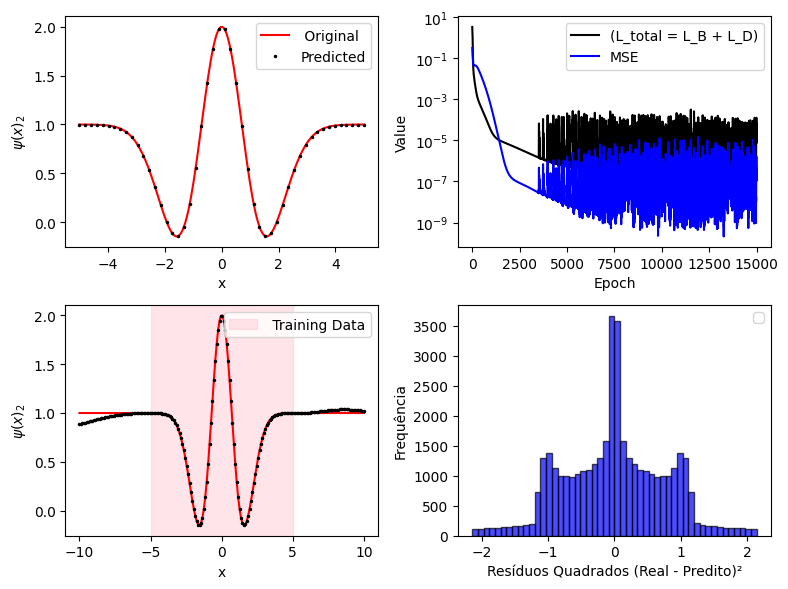

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

#treinamento na IA
# variáveis
# psi_2

A2  = 1
m  = 1
omega = 1
planck = 1
L_init = -5
L_end = 5


x = np.linspace(-3, 3, 100)
potencial = (1/2) * omega**2 * m * (x**2)

x = np.linspace(L_init, L_end, 100)
xi = np.sqrt((m * omega) / planck) * x
psi2 = A2 * (1 - 2*xi**2) * np.exp(-0.5*(xi**2))

class OdeSecond(nn.Module):
    def __init__(self):
        super(OdeSecond, self).__init__()
        self.dense1 = nn.Linear(1, 32)
        self.dense2 = nn.Linear(32, 32)
        self.dense3 = nn.Linear(32, 1)
        self.sigma = 0.5 # Ajuste o valor de sigma conforme necessário

    def gaussian_activation(self, x):
        return torch.exp(-0.5 * (x / self.sigma)** 2) * (1 - 2*x**2)

    def forward(self, x):
        x = self.gaussian_activation(self.dense1(x))
        x = self.gaussian_activation(self.dense2(x))
        return self.dense3(x)


# Funções de treinamento
def train_step(model, optimizer, loss_fn, x_train1, y_train1, L, xi):
    x_train_tensor = torch.tensor(x_train1, dtype=torch.float32, requires_grad=True)
    y_train_tensor = torch.tensor(y_train1, dtype=torch.float32)
    optimizer.zero_grad()

    x0 = torch.tensor([ L_init ], dtype=torch.float32, requires_grad=True)
    y0_exact = torch.tensor([ A2 * (1 - 2*(L_init**2)) * np.exp(-0.5*(L_init**2))], dtype=torch.float32)
    dy_dx0_exact = torch.tensor([  A2 * (2 * L_init**3 - 5 * L_init) * np.exp(-0.5*(L_init**2))  ], dtype=torch.float32)

    xL = torch.tensor([L_end ], dtype=torch.float32, requires_grad=True)
    yL_exact = torch.tensor([    A2 * (1 - 2*(L_end**2)) * np.exp(-0.5*(L_end**2))], dtype=torch.float32)

    y0_NN = model(x0)
    dy_dx0_NN = torch.autograd.grad(y0_NN.sum(), x0, create_graph=True)[0]
    yL_NN = model(xL)

    y_NN = model(x_train_tensor)
    dy_dx_NN = torch.autograd.grad(y_NN.sum(), x_train_tensor, create_graph=True)[0]
    d2y_dx2_NN = torch.autograd.grad(dy_dx_NN.sum(), x_train_tensor, create_graph=True)[0]

    loss = (
         loss_fn(y0_NN, y0_exact)
        +loss_fn(d2y_dx2_NN, np.exp(-0.5*(xi**2)) *A2*(11*(xi**2) - 2*(xi**4)- 5))
        +loss_fn(dy_dx0_NN, dy_dx0_exact)
        +loss_fn(yL_NN, yL_exact))

    loss.backward()
    optimizer.step()

    mse = nn.MSELoss()(y_NN, y_train_tensor)
    return loss.item(), mse.item()



def plot_grafics(model, x_train, y_train, x_test, y_test, loss_values, mse_values):
  """retorna o subplot da predição, erro, ruído e gráfico do conjunto de validação"""

  model.eval()
  x_test_tensor = torch.linspace(L_init, L_end, 50).unsqueeze(1)
  with torch.no_grad(): y_pred = model(x_test_tensor).numpy()
  fig, ax = plt.subplots(2, 2, figsize=(8, 6))

  #primeiro subplot previsão da rede neural
  ax[0, 0].plot(x_train, (omega*planck) + y_train, markersize=5,  color='red', alpha=1, label=r' Original')
  ax[0, 0].plot(x_test_tensor.numpy(),  (omega*planck) + y_pred,'.', markersize=3,  color='black',  alpha=1, label=r'Predicted')
  ax[0, 0].text(1000, 0,'', fontsize = 0.5)
  ax[0, 0].set_xlabel('x')
  ax[0, 0].set_ylabel(r'$\psi(x)_{2}$')
  ax[0, 0].legend()

  # segundo subplot = loss e mse
  ax[0, 1].set_yscale('log')
  ax[0, 1].plot(loss_values, color='black', label= '(L_total = L_B + L_D)')
  ax[0, 1].plot(mse_values, color='blue', label='MSE')
  ax[0, 1].text(4800, 0.25,'', fontsize=5)
  ax[0, 1].set_xlabel('Epoch')
  ax[0, 1].set_ylabel(r'Value')
  ax[0, 1].legend()

  # terceiro subplot = histograma
  x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
  with torch.no_grad(): y_pred_tensor = model(x_train_tensor)
  residuals = y_train - y_pred_tensor.numpy().flatten()
  squared = residuals

  ax[1, 1].hist(squared.flatten(), bins=50, color='blue', alpha=0.7, edgecolor='black')
  ax[1, 1].set_xlabel('Resíduos Quadrados (Real - Predito)²')
  ax[1, 1].set_ylabel('Frequência')
  #ax[1, 1].set_title('Histograma dos Resíduos Quadrados')
  ax[1, 1].legend()

  # quarto subplot
  x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
  with torch.no_grad():y_pred = model(x_test_tensor).numpy()  # Predição no conjunto de teste
  ax[1, 0].plot(x_test, (omega*planck) + y_test, markersize=5,  color='red', alpha=1)
  ax[1, 0].plot(x_test_tensor.numpy(),  (omega*planck) + y_pred,'.', markersize=3,  color='black',  alpha=1)
  ax[1, 0].text(1000, 0,'', fontsize = 0.5)
  ax[1, 0].axvspan(L_init, L_end, color='pink', alpha=0.4, label= f' Training Data')
  ax[1, 0].set_xlabel('x')
  ax[1, 0].set_ylabel(r'$\psi(x)_{2}$')
  ax[1, 0].legend()

  plt.savefig('graficoPSI_2.jpeg', dpi = 300,  bbox_inches='tight')  # bbox_inches='tight' ajuda a ajustar a borda)  # Ajuste de espaçamento entre subplots
  plt.tight_layout()
  plt.show()


if __name__ == "__main__":

    #treinamento
    x_train = np.sqrt((m*omega)/planck) * np.linspace(L_init, L_end, 200)[:, np.newaxis]
    y_train = A2 * (1 - 2*x_train**2) * np.exp(-0.5*(x_train**2))

    #test
    x_test = np.sqrt((m*omega)/planck) * np.linspace(L_init - 5, L_end + 5, 200)[:, np.newaxis]
    y_test = A2 * (1 - 2*x_test**2) * np.exp(-0.5*(x_test**2))

    xi = torch.tensor(x_train, dtype=torch.float32).detach()

    model = OdeSecond()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    loss_fn = nn.MSELoss()
    epochs = 15000
    loss_values = []
    mse_values = []

    for epoch in range(epochs):
        loss, mse = train_step(model, optimizer, loss_fn, x_train, y_train, L_init, xi)
        loss_values.append(loss)
        mse_values.append(mse)
        if epoch % 100 == 0:
            print(f"Epoch [{epoch + 1}/{epochs}], Loss: {loss:.10f}, MSE: {mse:.10f}")

    print("\nModel Summary:")
    print(model)

    plot_grafics(model, x_train, y_train, x_test, y_test, loss_values, mse_values)


Epoch [1/7000], Loss: 19.4625530243, MSE: 1.0751866102
Epoch [101/7000], Loss: 0.0102177355, MSE: 0.0310306381
Epoch [201/7000], Loss: 0.0028522199, MSE: 0.0080524748
Epoch [301/7000], Loss: 0.0009991359, MSE: 0.0015684224
Epoch [401/7000], Loss: 0.0005544982, MSE: 0.0003428028
Epoch [501/7000], Loss: 0.0004006145, MSE: 0.0000893874
Epoch [601/7000], Loss: 0.0003117262, MSE: 0.0000198927
Epoch [701/7000], Loss: 0.0002488513, MSE: 0.0000048443
Epoch [801/7000], Loss: 0.0002018821, MSE: 0.0000091354
Epoch [901/7000], Loss: 0.0001659378, MSE: 0.0000179868
Epoch [1001/7000], Loss: 0.0001379411, MSE: 0.0000251920
Epoch [1101/7000], Loss: 0.0001157836, MSE: 0.0000290438
Epoch [1201/7000], Loss: 0.0000979915, MSE: 0.0000299161
Epoch [1301/7000], Loss: 0.0000835123, MSE: 0.0000288552
Epoch [1401/7000], Loss: 0.0000715889, MSE: 0.0000268364
Epoch [1501/7000], Loss: 0.0000616695, MSE: 0.0000245589
Epoch [1601/7000], Loss: 0.0000533541, MSE: 0.0000224165
Epoch [1701/7000], Loss: 0.0000463463, MSE


Model Summary:
OdeSecond(
  (dense1): Linear(in_features=1, out_features=32, bias=True)
  (dense2): Linear(in_features=32, out_features=32, bias=True)
  (dense3): Linear(in_features=32, out_features=1, bias=True)
)


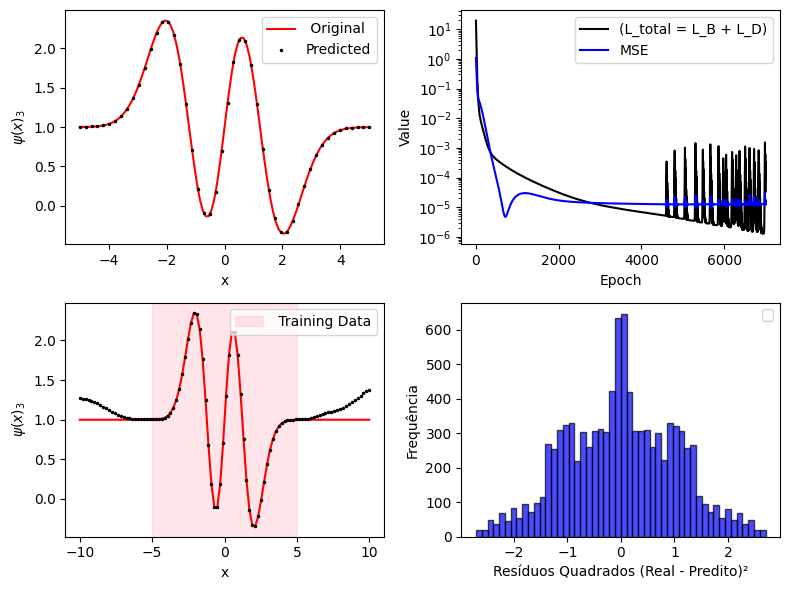

In [ ]:
# psi_3
A3  = 1
m  = 1
omega = 1
planck = 1
L_init = -5
L_end = 5

x = np.linspace(L_init, L_end, 100)
potencial = (1/2) * omega**2 * m * (x**2)
xi = torch.tensor(x, dtype=torch.float32).detach()
psi3 = A3 * (1 - 2*xi**2) * np.exp(-0.5*(xi**2))

class OdeSecond(nn.Module):
    def __init__(self):
        super(OdeSecond, self).__init__()
        self.dense1 = nn.Linear(1, 32)
        self.dense2 = nn.Linear(32, 32)
        self.dense3 = nn.Linear(32, 1)
        self.sigma = 1 # Ajuste o valor de sigma conforme necessário

    def gaussian_activation(self, x):
        return torch.exp(-0.5 * (x / self.sigma)** 2)*(3*x - 2*x**3)
    def forward(self, x):
        x = self.gaussian_activation(self.dense1(x))
        x = self.gaussian_activation(self.dense2(x))
        return self.dense3(x)


# Funções de treinamento
def train_step(model, optimizer, loss_fn, x_train1, y_train1, L, xi):
    x_train_tensor = torch.tensor(x_train1, dtype=torch.float32, requires_grad=True)
    y_train_tensor = torch.tensor(y_train1, dtype=torch.float32)
    optimizer.zero_grad()

    x0 = torch.tensor([ L_init ], dtype=torch.float32, requires_grad=True)
    y0_exact = torch.tensor([ A3 * (2 * L_init**4 - 9*L_init**2  + 3)* np.exp(-0.5*(L_init**2))], dtype=torch.float32)
    dy_dx0_exact = torch.tensor([  A3 * (2*L_init**4 - 9*L_init**2 +3) * np.exp(-0.5*(L_init**2))  ], dtype=torch.float32)

    xL = torch.tensor([L_end ], dtype=torch.float32, requires_grad=True)
    yL_exact = torch.tensor([   A3 * (2 * L_end**4 - 9*L_end**2  + 3)* np.exp(-0.5*(L_end**2)) ], dtype=torch.float32)

    y0_NN = model(x0)
    dy_dx0_NN = torch.autograd.grad(y0_NN.sum(), x0, create_graph=True)[0]
    yL_NN = model(xL)

    y_NN = model(x_train_tensor)
    dy_dx_NN = torch.autograd.grad(y_NN.sum(), x_train_tensor, create_graph=True)[0]
    d2y_dx2_NN = torch.autograd.grad(dy_dx_NN.sum(), x_train_tensor, create_graph=True)[0]

    loss = (
         loss_fn(y0_NN, y0_exact)
        +loss_fn(d2y_dx2_NN, np.exp(-0.5*(xi**2)) * A3 * (-2 * xi**5 + 17*xi**3 - 21*xi))
        +loss_fn(dy_dx0_NN, dy_dx0_exact)
        +loss_fn(yL_NN, yL_exact))

    loss.backward()
    optimizer.step()

    mse = nn.MSELoss()(y_NN, y_train_tensor)
    return loss.item(), mse.item()

def plot_grafics(model, x_train, y_train, x_test, y_test, loss_values, mse_values):
  """retorna o subplot da predição, erro, ruído e gráfico do conjunto de validação"""

  model.eval()
  x_test_tensor = torch.linspace(L_init, L_end, 50).unsqueeze(1)
  with torch.no_grad(): y_pred = model(x_test_tensor).numpy()
  fig, ax = plt.subplots(2, 2, figsize=(8, 6))

  #primeiro subplot previsão da rede neural
  ax[0, 0].plot(x_train, (omega*planck) + y_train, markersize=5,  color='red', alpha=1, label=r' Original')
  ax[0, 0].plot(x_test_tensor.numpy(),  (omega*planck) + y_pred,'.', markersize=3,  color='black',  alpha=1, label=r'Predicted')
  ax[0, 0].text(1000, 0,'', fontsize = 0.5)
  ax[0, 0].set_xlabel('x')
  ax[0, 0].set_ylabel(r'$\psi(x)_{3}$')
  ax[0, 0].legend()

  # segundo subplot = loss e mse
  ax[0, 1].set_yscale('log')
  ax[0, 1].plot(loss_values, color='black', label= '(L_total = L_B + L_D)')
  ax[0, 1].plot(mse_values, color='blue', label='MSE')
  ax[0, 1].text(4800, 0.25,'', fontsize=5)
  ax[0, 1].set_xlabel('Epoch')
  ax[0, 1].set_ylabel(r'Value')
  ax[0, 1].legend()

  # terceiro subplot = histograma
  x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
  with torch.no_grad(): y_pred_tensor = model(x_train_tensor)
  residuals = y_train - y_pred_tensor.numpy().flatten()
  squared = residuals

  ax[1, 1].hist(squared.flatten(), bins=50, color='blue', alpha=0.7, edgecolor='black')
  ax[1, 1].set_xlabel('Resíduos Quadrados (Real - Predito)²')
  ax[1, 1].set_ylabel('Frequência')
  #ax[1, 1].set_title('Histograma dos Resíduos Quadrados')
  ax[1, 1].legend()

  # quarto subplot
  x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
  with torch.no_grad():y_pred = model(x_test_tensor).numpy()  # Predição no conjunto de teste
  ax[1, 0].plot(x_test, (omega*planck) + y_test, markersize=5,  color='red', alpha=1)
  ax[1, 0].plot(x_test_tensor.numpy(),  (omega*planck) + y_pred,'.', markersize=3,  color='black',  alpha=1)
  ax[1, 0].text(1000, 0,'', fontsize = 0.5)
  ax[1, 0].axvspan(L_init, L_end, color='pink', alpha=0.4, label= f' Training Data')
  ax[1, 0].set_xlabel('x')
  ax[1, 0].set_ylabel(r'$\psi(x)_{3}$')
  ax[1, 0].legend()

  plt.savefig('graficoPSI_3.jpeg', dpi = 300,  bbox_inches='tight')  # bbox_inches='tight' ajuda a ajustar a borda)  # Ajuste de espaçamento entre subplots
  plt.tight_layout()
  plt.show()



if __name__ == "__main__":
    x_train = np.sqrt((m*omega)/planck) * np.linspace(L_init, L_end, 100)[:, np.newaxis]
    y_train = A3*(3*x_train - 2*x_train**3) * np.exp(-0.5*(x_train**2))

    x_test = np.sqrt((m*omega)/planck) * np.linspace(L_init-5, L_end+5, 100)[:, np.newaxis]
    y_test = A3*(3*x_test - 2*x_test**3) * np.exp(-0.5*(x_test**2))

    xi = torch.tensor(x_train, dtype=torch.float32).detach()

    model = OdeSecond()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    loss_fn = nn.MSELoss()

    epochs = 7000
    loss_values = []
    mse_values = []
    for epoch in range(epochs):
        loss, mse = train_step(model, optimizer, loss_fn, x_train, y_train, L_init, xi)
        loss_values.append(loss)
        mse_values.append(mse)
        if epoch % 100 == 0:
            print(f"Epoch [{epoch + 1}/{epochs}], Loss: {loss:.10f}, MSE: {mse:.10f}")

    print("\nModel Summary:")
    print(model)

    func_densidade = []
    func_loss = []
    func_solucao =  []
    plot_grafics(model, x_train, y_train, x_test, y_test, loss_values, mse_values)


Epoch [1/10000], Loss: 12.3010187149, MSE: 0.5443994999
Epoch [101/10000], Loss: 0.0141148958, MSE: 0.0346694589
Epoch [201/10000], Loss: 0.0021239093, MSE: 0.0167417265
Epoch [301/10000], Loss: 0.0007861080, MSE: 0.0111725144
Epoch [401/10000], Loss: 0.0004635077, MSE: 0.0081056478
Epoch [501/10000], Loss: 0.0003029366, MSE: 0.0057318769
Epoch [601/10000], Loss: 0.0002021705, MSE: 0.0038835499
Epoch [701/10000], Loss: 0.0001372337, MSE: 0.0025250081
Epoch [801/10000], Loss: 0.0000955320, MSE: 0.0015849861
Epoch [901/10000], Loss: 0.0000690269, MSE: 0.0009686393
Epoch [1001/10000], Loss: 0.0000523362, MSE: 0.0005826149
Epoch [1101/10000], Loss: 0.0000418000, MSE: 0.0003496917
Epoch [1201/10000], Loss: 0.0000349806, MSE: 0.0002130385
Epoch [1301/10000], Loss: 0.0000303222, MSE: 0.0001342534
Epoch [1401/10000], Loss: 0.0000268894, MSE: 0.0000891035
Epoch [1501/10000], Loss: 0.0000241563, MSE: 0.0000630892
Epoch [1601/10000], Loss: 0.0000218464, MSE: 0.0000478647
Epoch [1701/10000], Loss:

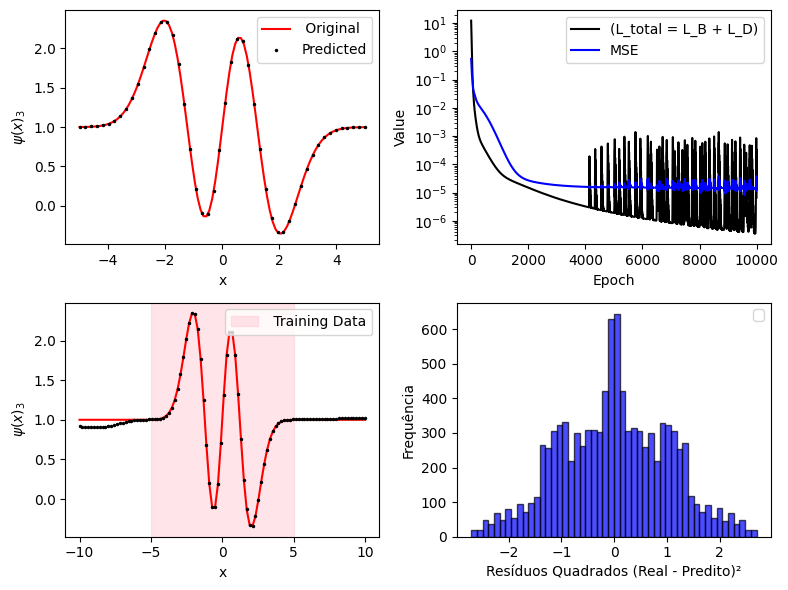

In [ ]:
# psi_3
A3  = 1
m  = 1
omega = 1
planck = 1
L_init = -5
L_end = 5

x = np.linspace(L_init, L_end, 100)
potencial = (1/2) * omega**2 * m * (x**2)
xi = torch.tensor(x, dtype=torch.float32).detach()
psi3 = A3 * (1 - 2*xi**2) * np.exp(-0.5*(xi**2))

class OdeSecond(nn.Module):
    def __init__(self):
        super(OdeSecond, self).__init__()
        self.dense1 = nn.Linear(1, 32)
        self.dense2 = nn.Linear(32, 32)
        self.dense3 = nn.Linear(32, 1)
        self.sigma = 0.5 # Ajuste o valor de sigma conforme necessário

    def gaussian_activation(self, x):
        return torch.exp(-0.5 * (x / self.sigma)** 2)*(3*x - 2*x**3)
    def forward(self, x):
        x = self.gaussian_activation(self.dense1(x))
        x = self.gaussian_activation(self.dense2(x))
        return self.dense3(x)


# Funções de treinamento
def train_step(model, optimizer, loss_fn, x_train1, y_train1, L, xi):
    x_train_tensor = torch.tensor(x_train1, dtype=torch.float32, requires_grad=True)
    y_train_tensor = torch.tensor(y_train1, dtype=torch.float32)
    optimizer.zero_grad()

    x0 = torch.tensor([ L_init ], dtype=torch.float32, requires_grad=True)
    y0_exact = torch.tensor([ A3 * (2 * L_init**4 - 9*L_init**2  + 3)* np.exp(-0.5*(L_init**2))], dtype=torch.float32)
    dy_dx0_exact = torch.tensor([  A3 * (2*L_init**4 - 9*L_init**2 +3) * np.exp(-0.5*(L_init**2))  ], dtype=torch.float32)

    xL = torch.tensor([L_end ], dtype=torch.float32, requires_grad=True)
    yL_exact = torch.tensor([   A3 * (2 * L_end**4 - 9*L_end**2  + 3)* np.exp(-0.5*(L_end**2)) ], dtype=torch.float32)

    y0_NN = model(x0)
    dy_dx0_NN = torch.autograd.grad(y0_NN.sum(), x0, create_graph=True)[0]
    yL_NN = model(xL)

    y_NN = model(x_train_tensor)
    dy_dx_NN = torch.autograd.grad(y_NN.sum(), x_train_tensor, create_graph=True)[0]
    d2y_dx2_NN = torch.autograd.grad(dy_dx_NN.sum(), x_train_tensor, create_graph=True)[0]

    loss = (
         loss_fn(y0_NN, y0_exact)
        +loss_fn(d2y_dx2_NN, np.exp(-0.5*(xi**2)) * A3 * (-2 * xi**5 + 17*xi**3 - 21*xi))
        +loss_fn(dy_dx0_NN, dy_dx0_exact)
        +loss_fn(yL_NN, yL_exact))

    loss.backward()
    optimizer.step()

    mse = nn.MSELoss()(y_NN, y_train_tensor)
    return loss.item(), mse.item()

def plot_grafics(model, x_train, y_train, x_test, y_test, loss_values, mse_values):
  """retorna o subplot da predição, erro, ruído e gráfico do conjunto de validação"""

  model.eval()
  x_test_tensor = torch.linspace(L_init, L_end, 50).unsqueeze(1)
  with torch.no_grad(): y_pred = model(x_test_tensor).numpy()
  fig, ax = plt.subplots(2, 2, figsize=(8, 6))

  #primeiro subplot previsão da rede neural
  ax[0, 0].plot(x_train, (omega*planck) + y_train, markersize=5,  color='red', alpha=1, label=r' Original')
  ax[0, 0].plot(x_test_tensor.numpy(),  (omega*planck) + y_pred,'.', markersize=3,  color='black',  alpha=1, label=r'Predicted')
  ax[0, 0].text(1000, 0,'', fontsize = 0.5)
  ax[0, 0].set_xlabel('x')
  ax[0, 0].set_ylabel(r'$\psi(x)_{3}$')
  ax[0, 0].legend()

  # segundo subplot = loss e mse
  ax[0, 1].set_yscale('log')
  ax[0, 1].plot(loss_values, color='black', label= '(L_total = L_B + L_D)')
  ax[0, 1].plot(mse_values, color='blue', label='MSE')
  ax[0, 1].text(4800, 0.25,'', fontsize=5)
  ax[0, 1].set_xlabel('Epoch')
  ax[0, 1].set_ylabel(r'Value')
  ax[0, 1].legend()

  # terceiro subplot = histograma
  x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
  with torch.no_grad(): y_pred_tensor = model(x_train_tensor)
  residuals = y_train - y_pred_tensor.numpy().flatten()
  squared = residuals

  ax[1, 1].hist(squared.flatten(), bins=50, color='blue', alpha=0.7, edgecolor='black')
  ax[1, 1].set_xlabel('Resíduos Quadrados (Real - Predito)²')
  ax[1, 1].set_ylabel('Frequência')
  #ax[1, 1].set_title('Histograma dos Resíduos Quadrados')
  ax[1, 1].legend()

  # quarto subplot
  x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
  with torch.no_grad():y_pred = model(x_test_tensor).numpy()  # Predição no conjunto de teste
  ax[1, 0].plot(x_test, (omega*planck) + y_test, markersize=5,  color='red', alpha=1)
  ax[1, 0].plot(x_test_tensor.numpy(),  (omega*planck) + y_pred,'.', markersize=3,  color='black',  alpha=1)
  ax[1, 0].text(1000, 0,'', fontsize = 0.5)
  ax[1, 0].axvspan(L_init, L_end, color='pink', alpha=0.4, label= f' Training Data')
  ax[1, 0].set_xlabel('x')
  ax[1, 0].set_ylabel(r'$\psi(x)_{3}$')
  ax[1, 0].legend()

  plt.savefig('graficoPSI_3.jpeg', dpi = 300,  bbox_inches='tight')  # bbox_inches='tight' ajuda a ajustar a borda)  # Ajuste de espaçamento entre subplots
  plt.tight_layout()
  plt.show()



if __name__ == "__main__":
    x_train = np.sqrt((m*omega)/planck) * np.linspace(L_init, L_end, 100)[:, np.newaxis]
    y_train = A3*(3*x_train - 2*x_train**3) * np.exp(-0.5*(x_train**2))

    x_test = np.sqrt((m*omega)/planck) * np.linspace(L_init-5, L_end+5, 100)[:, np.newaxis]
    y_test = A3*(3*x_test - 2*x_test**3) * np.exp(-0.5*(x_test**2))

    xi = torch.tensor(x_train, dtype=torch.float32).detach()

    model = OdeSecond()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    loss_fn = nn.MSELoss()

    epochs = 10000
    loss_values = []
    mse_values = []
    for epoch in range(epochs):
        loss, mse = train_step(model, optimizer, loss_fn, x_train, y_train, L_init, xi)
        loss_values.append(loss)
        mse_values.append(mse)
        if epoch % 100 == 0:
            print(f"Epoch [{epoch + 1}/{epochs}], Loss: {loss:.10f}, MSE: {mse:.10f}")

    print("\nModel Summary:")
    print(model)

    func_densidade = []
    func_loss = []
    func_solucao =  []
    plot_grafics(model, x_train, y_train, x_test, y_test, loss_values, mse_values)
